In [1]:
import pandas as pd
import numpy as np

import neologdn
import MeCab

import re

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

### テキストデータの読み込み
読み込むデータは：https://www.aozora.gr.jp/cards/001779/card56680.html　のテキストファイル(ルビあり)

In [2]:
# with open('sakasuno_kaijin.txt', 'r') as f:とすると「'cp932' codec can't decode byte 0xef in position 0: illegal multibyte sequence」のエラーが発生
# with open('sakasuno_kaijin.txt', 'rb') as f:
    # text = f.read()
# これだと永遠と「b'\xef\xbb\xbf\xe3\x82.....」が読み込まれるのでdecodeする必要あり
with open('sakasuno_kaijin.txt', 'rb') as f:
    binary_data = f.read()
# メモ帳の文字コードを「UTF-8」で保存していた場合はdecode('utf-8')
# text = binary_data.decode('utf-8')
# メモ帳の文字コードを「ANSI」で保存していた場合はdecode('shift-jis')
text = binary_data.decode('shift-jis')

### 正規表現で該当文字列を削除
#### タイトル名、作者名、-（ハイフン）内の文字列を削除
##### 参考URL：http://www-creators.com/archives/4278

In [3]:
# -（ハイフン）が5つ以上:-{5,}
# {n,}:直前の文字がn回以上に一致
# 参考URL：http://hodade.com/seiki/page.php?study1
# split関数を使うことでtextはリスト型になる
# 今回は-（ハイフン）が5つ以上の箇所で区切ることになるのでtext[0]=タイトル名、作者名 text[1]=【テキスト中に現れる記号について】text[2]=本文 となる
# -（ハイフン）の前に「\」を付けることで正規表現の-（ハイフン）ではなく単なる文字としての-（ハイフン）という意味に変更している
# 「\」:直後の文字を正規表現の記号（メタ文字）として扱わないことを指定
text = re.split('\-{5,}', text)[2]

#### 文末の「（スペース）底本：」以降の文字列を削除

In [4]:
text = re.split('底本：', text)[0]

#### 空白文字(スペースやタブ、改行)を削除

In [5]:
# strip関数は文字の間に入っている空白を削除しない
text = text.strip()

#### 《》：ルビを削除

In [6]:
# 置換後の文字列 = re.sub(正規表現, 置換後文字, 置換される文字列 [, 置換回数])
# 「.」:あらゆる一文字 「.」を４つ並べば、何の文字かを問わずに「４文字の文字列」を表す
# しかしながら、文字数の分だけ何度も「.」を繰り返し入力するのは大変。
# そんな時、そのパターンが何回繰り返されるかを単純に表現するのが「+」
# 「+」:直前のパターンの１回以上の繰り返しを表す
# 「?」:０回か、１回の繰り返し
text = re.sub('《.+》', '', text)

#### ｜：ルビの付く文字列の始まりを特定する記号を削除

In [7]:
text = text.replace('｜', '')

#### ［＃］：入力者注　主に外字の説明や、傍点の位置の指定 する記号を削除

In [8]:
text = re.sub('［＃.+］', '', text)

#### neologdnで正規化、Mecab + neologd 辞書による形態素解析し、品詞で単語を絞った後、出現頻度10以上の単語を抽出してリストに格納、最後にリストに格納した単語すべてをカンマで繋げて文字列型にする関数

In [9]:
def get_mecabed_word_text(text):
    text_normalization = neologdn.normalize(text)
    neologd_tagger = MeCab.Tagger('-Ochasen -d C:\mecab-ipadic-neologd')
    
    # neologd_tagger.parse(text)で各単語の原形、品詞などが1行で連続して表示される
    # 原形、品詞などの間には「\t」が、分かち書きされた単語と単語の区切りには「\n」が表示される
    # 例: '空い\tアイ\t空く\t動詞-自立\t五段・カ行イ音便\t連用タ接続\nた\tタ\tた\t助動詞\t特殊・タ\t基本形\n時間....
    # まずはparse()で分かち書きした単語群は1つの文字列型になっているので「\n」で区切り、リスト型にする
    wakati_text_list = neologd_tagger.parse(text_normalization).split('\n')
    # 「\n」で区切り、リスト型にした結果の例は下記
    # ['空い\tアイ\t空く\t動詞-自立\t五段・カ行イ音便\t連用タ接続', ：リスト0番目
    # 'た\tタ\tた\t助動詞\t特殊・タ\t基本形',：リスト1番目
    # '時間\tジカン\t時間\t名詞-副詞可能\t\t',：リスト2番目
    
    ##【形態素解析結果を格納したリストから特定の品詞（品詞詳細部分まで考慮に入れた場合）のみ抽出】
    # 抽出したい品詞のリストを作成（完全一致）
    # 品詞参考URL：http://miner.hatenablog.com/entry/323
    hinshi_list = ['名詞-一般', '名詞-形容動詞語幹', '名詞-固有名詞-一般',  '名詞-サ変接続', '形容詞-自立', '形容詞-接尾', '形容詞-非自立', '動詞-自立', '動詞-接尾', '動詞-非自立', '副詞-一般', '副詞-助詞類接続']
    # hinshi_list = ('名詞-一般', '名詞-サ変接続', '名詞-固有名詞', '名詞-形容動詞語幹'...)とタプルでも同じ結果
    original_form_list =[]# 単語の「原形」のみ格納する(品詞情報は単語頻度を求める際に必要ないので除外)
    
    # parse() の出力結果の最後は「EOS」という文字のみ
    # EOSのとき、pos = wakati.split('\t')[3]の要素はないので下記forループを実行すると「list index out of range」とエラーを発生させてしまう
    # よってEOSのときは条件分岐if~breakでforループから抜け出すよう記述
    for wakati in wakati_text_list:
        surface = wakati.split('\t')[0]
        if surface == 'EOS':
            break
        else:
            pos = wakati.split('\t')[3]
            if pos in hinshi_list:# posはhinshi_listの中の要素と完全一致していないと抽出できない
                original_form_list.append(wakati.split('\t')[2])
    # ここまでで品詞によって単語を絞った
    
    ##【単語の出現頻度を求め、出現頻度10以上の単語のみ抽出】
    # まずは単語の出現頻度を求める
    import collections
    count = collections.Counter(original_form_list)
    word_count_list = count.most_common()
    word_count_list# word_count_listは全体がリスト型でリスト内に('する', 4), ('ぼんやり', 3),,,,といった単語とその出現頻度がタプルで格納されている
    # 次に出現頻度が10以上の単語のみ抽出する
    Frequency10_word_list = []
    for word_count in word_count_list:
        if word_count[1] > 9:
            Frequency10_word_list.append(word_count[0])
    
    Frequency10_word_text = ','.join(map(str, Frequency10_word_list))
    return Frequency10_word_text

In [10]:
# 関数を実行
mecabed_word_text = get_mecabed_word_text(text)
mecabed_word_text[:5]# 単語の抽出がうまくいっているか確認、「い」「る」「,」「す」「る」の5文字が抽出される

'いる,する'

# WordCloudで単語の頻度図を描画

In [11]:
from wordcloud import WordCloud
# python3.6系だとimportできない
# コマンドプロンプトに「conda install -c anaconda pillow」と打って実行するとimportできた
# 参考URL：https://yondakana.blogspot.com/2018/01/from-pil-import-image.html

In [12]:
# WordCloudの引数のfont_pathの設定から行う
# C:\Users\xxx\Anaconda3\Lib\site-packages\matplotlib\mpl-data\fonts\ttf の中にある「ipaexg.ttf」をC:\Windows\Fonts ディレクトリの中に格納してから実行する
fpath = r"C:\Windows\Fonts\ipaexg.ttf"
wordcloud = WordCloud(background_color="white",font_path=fpath, width=900, height=500)

In [13]:
wordcloud_output = wordcloud.generate(mecabed_word_text)

(-0.5, 899.5, 499.5, -0.5)

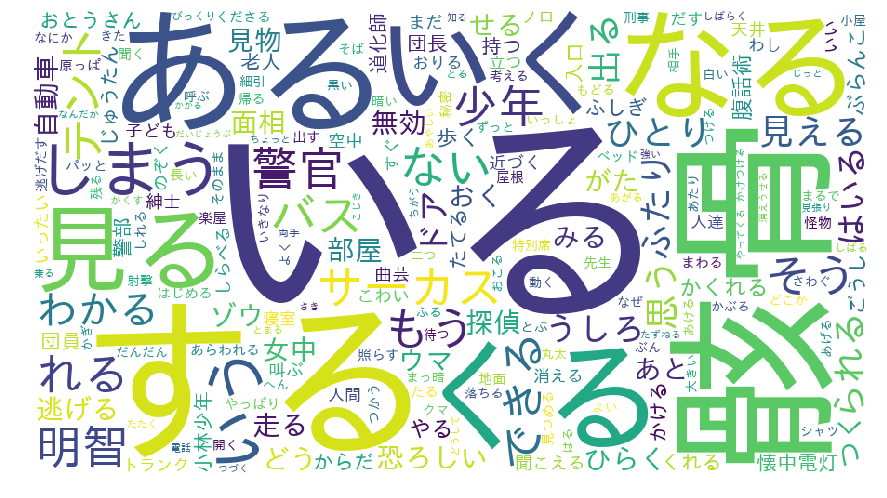

In [14]:
# 単語の頻度図を描画
plt.figure(figsize=(15,12))
plt.imshow(wordcloud_output)
plt.axis("off")

##### 参考1:udemy講座「【TensorFlow・Keras・Python3で学ぶ】時系列データ処理入門（RNN/LSTM, Word2Vec)」
##### 参考2:https://datumstudio.jp/blog/python%e3%81%ab%e3%82%88%e3%82%8b%e6%97%a5%e6%9c%ac%e8%aa%9e%e5%89%8d%e5%87%a6%e7%90%86%e5%82%99%e5%bf%98%e9%8c%b2